In [1]:
!pip install -q transformers datasets evaluate



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 7.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation


processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


In [4]:
from PIL import Image
import requests
import io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


In [60]:
X_train = np.load('/content/drive/MyDrive/healthcare_practicals/miniproject/data/X_guys_2d.npy')
y_train = np.load('/content/drive/MyDrive/healthcare_practicals/miniproject/data/y_guys_2d.npy')
print(X_train.shape, y_train.shape)

# X_train = centring(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(valtest_images, valtest_labels, test_size=0.5, random_state=42)


X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0],1,X_val.shape[1],X_val.shape[2])
# X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1],X_test.shape[2])
print(X_train.shape, y_train.shape)


(317, 128, 128) (317, 352, 352)
(253, 1, 128, 128) (253, 352, 352)


In [7]:
from torch.utils.data import Dataset, DataLoader

class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here 
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)



In [8]:
def preprocess_grayscale_image(image, size):
    if len(image.size) == 2:
        image = np.stack((image, image, image), axis=-1)
    return Image.fromarray(image).resize((size, size))

In [17]:
def val(net, val_dataloader, loss_fn, prompt):
    net.eval()  #Put the model in eval mode
    total_loss = 0 
    total_raw_loss = 0   
    pred_store = []
    true_store = []
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)

            # Data Processing to let CLIPSeg accept
            data = data.squeeze(1)
            images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
            images = [preprocess_grayscale_image(img, 128) for img in images]
            inputs = processor(text=[prompt]*len(images), images=images, padding="max_length", return_tensors="pt")


            # Forward pass and compute loss
            outputs = model(**inputs)
            outputs = torch.sigmoid(outputs.logits).double()
            loss = loss_fn(outputs, target)


            total_loss += loss
        av_loss = total_loss / batches
        av_raw_loss = total_raw_loss / batches
        
    av_loss = av_loss.detach().numpy()
    
    print(f"Prompt: {prompt}, Average Loss: {av_loss}")
    print('\n')
    return av_loss, av_raw_loss, outputs

In [57]:
net = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
net = net.load_state_dict(torch.load("/content/drive/MyDrive/healthcare_practicals/miniproject/bestCLIPSeg.pkl", map_location=torch.device("cpu")))


prompts = ["brain", "cerebral cortex", "cortex", "gray matter", "noodle", "cranium", "encephalon", "medulla oblongata"]
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

class_loss = nn.BCELoss()

losses = []

for prompt in prompts:
    print(prompt)
    val_loss, val_loss_raw, last_val_pred = val(net, val_dataloader, class_loss, prompt)
    losses.append(val_loss)

losses = [float(l) for l in losses]
print(" & ".join(losses))

brain
Prompt: brain, Average Loss: 0.5464392309857744


cerebral cortex
Prompt: cerebral cortex, Average Loss: 1.2762532184184938


cortex
Prompt: cortex, Average Loss: 1.0354415416292204


gray matter
Prompt: gray matter, Average Loss: 0.6097333212430093


noodle
Prompt: noodle, Average Loss: 1.4676031974133132


cranium
Prompt: cranium, Average Loss: 0.6458215716152922


encephalon
Prompt: encephalon, Average Loss: 1.254391075446907


medulla oblongata
Prompt: medulla oblongata, Average Loss: 0.6065124324823271




TypeError: ignored

In [66]:
losses = [str(round(float(l),5)) for l in losses]
print(" & ".join(losses))

0.54644 & 1.27625 & 1.03544 & 0.60973 & 1.4676 & 0.64582 & 1.25439 & 0.60651


In [48]:
def val_img(net, val_dataloader, loss_fn, prompt):
    net.eval()  #Put the model in eval mode
    total_loss = 0 
    total_raw_loss = 0   
    pred_store = []
    true_store = []
    batches = 0
    
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)

            # Data Processing to let CLIPSeg accept
            data = data.squeeze(1)
            images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
            images = [preprocess_grayscale_image(img, 128) for img in images]
            encoded_image = processor(images=images, return_tensors="pt")
            img_prompt = processor(images=[prompt]*len(images), return_tensors="pt")


            # Forward pass and compute loss
            outputs = model(**encoded_image, conditional_pixel_values=img_prompt.pixel_values)
            outputs = torch.sigmoid(outputs.logits).double()
            loss = loss_fn(outputs, target)


            total_loss += loss
        av_loss = total_loss / batches
        av_raw_loss = total_raw_loss / batches
        
    av_loss = av_loss.detach().numpy()
    
    print(f"Prompt: {prompt}, Average Loss: {av_loss}")
    print('\n')
    return av_loss, av_raw_loss, outputs

In [45]:
from PIL import Image
import os

# Set the directory path
directory = '/content/drive/MyDrive/healthcare_practicals/miniproject/data/Prompts/'

# Initialize an empty list to store the images
image_prompts = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Open the image file and append it to the list
        img = Image.open(directory + filename).convert("RGB")
        image_prompts.append(img)


In [64]:
# image_prompts[0].channels
print(image_prompts[0].convert("RGB"))
mat = np.array(image_prompts[0])
mat = image_prompts[0].convert("RGB")

img_prompt = processor(images=[mat], return_tensors="pt")

net = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
net = net.load_state_dict(torch.load("/content/drive/MyDrive/healthcare_practicals/miniproject/bestCLIPSeg.pkl", map_location=torch.device("cpu")))

image = Image.fromarray(X_train[0].squeeze(0))
image = image.convert("L")
image = preprocess_grayscale_image(image, 128)
inputs = processor(text=["brain"], images=[image], padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = net(**inputs)

print(outputs.loss)
outputs = torch.sigmoid(outputs.logits)


<PIL.Image.Image image mode=RGB size=900x697 at 0x7FB3FD343A00>
None


In [51]:
net = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

class_loss = nn.BCELoss()

losses = []
samples = []

for prompt in image_prompts:
    val_loss, val_loss_raw, last_val_pred = val_img(net, val_dataloader, class_loss, prompt)
    losses.append(val_loss)
    samples.append(last_val_pred)

losses = [str(float(l)) for l in losses]
print(" & ".join(losses))

Prompt: <PIL.Image.Image image mode=RGB size=900x697 at 0x7FB528FC8910>, Average Loss: 0.4247979985034597


Prompt: <PIL.Image.Image image mode=RGB size=560x320 at 0x7FB46E788C10>, Average Loss: 0.4091897779499967


Prompt: <PIL.Image.Image image mode=RGB size=1200x1200 at 0x7FB4088D0FA0>, Average Loss: 0.4038982076685428


Prompt: <PIL.Image.Image image mode=RGB size=700x483 at 0x7FB403918100>, Average Loss: 0.4019796721175159


Prompt: <PIL.Image.Image image mode=RGB size=1024x512 at 0x7FB403ED6A00>, Average Loss: 0.4030405706568266


0.4247979985034597 & 0.4091897779499967 & 0.4038982076685428 & 0.4019796721175159 & 0.4030405706568266


5


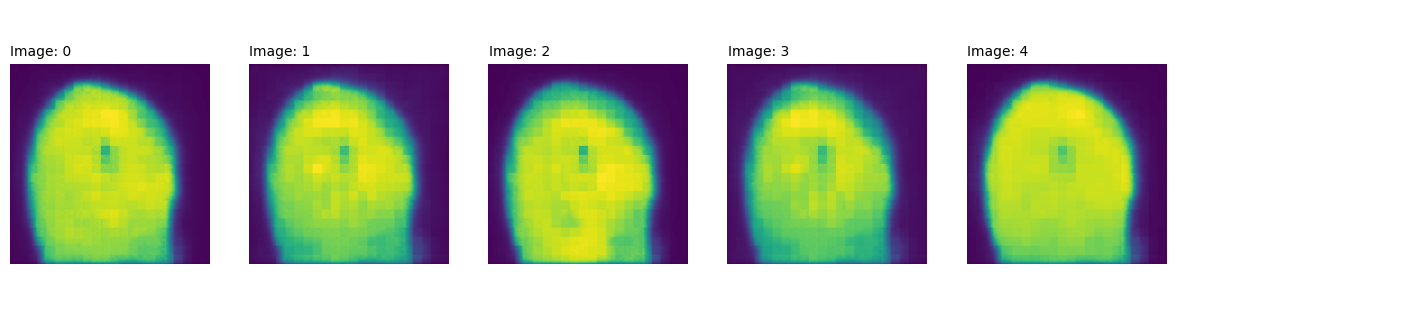

In [55]:
import matplotlib.pyplot as plt
print(len(image_prompts))
_, ax = plt.subplots(1, len(image_prompts) + 1, figsize=(3*(len(image_prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]

[ax[i].imshow(torch.sigmoid(samples[i][0])) for i in range(len(image_prompts))];
[ax[i].text(0, -15, f"Image: {i}") for i, prompt in enumerate(image_prompts)];